In [1]:
import nest_asyncio
nest_asyncio.apply()

from hddCRP.modelBuilder import cdCRP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statannotations.Annotator import Annotator
from sklearn.metrics import roc_auc_score

import itertools

from pandas.api.types import CategoricalDtype
import os


In [2]:
overwrite_existing_results = False
results_directory = "Results/population/LOO_tau/"

if(not os.path.exists(results_directory)):
    os.makedirs(results_directory)

data_filename = 'data/Data_turns_all_by_session.pkl';
with open(data_filename, 'rb') as data_file:
    data = pickle.load(data_file)

groups = ["uniform", "diverse"]
print("groups = " + str(groups))

session_numbers = None#[1]; # index by 1
number_of_trials    = 50;

action_labels = [0,1,2]

groups = ['uniform', 'diverse']


In [3]:
def run_fit(stan_seed, sequences_c, session_types_c, subject_labels_c, population_labels_c, subject_label, context_depth, nback_depth, enable_tau):
    model = cdCRP(sequences_c,
                    session_labels=session_types_c,
                    subject_labels=subject_labels_c,
                    population_labels=population_labels_c,
                    possible_observations=action_labels);
    model.same_nback_depth = nback_depth
    model.context_depth = context_depth
    model.within_session_decay_enabled = enable_tau

    model.build(random_seed=stan_seed);
    model.fit_model()

    fit_df  = model.fit.to_frame()
    summary_df = model.fit_summary()

    fit_df["loo_subject"]   = subject_label
    summary_df["loo_subject"] = subject_label

    if(session_numbers is None):
        summary_df["number_of_trials"] = number_of_trials
        summary_df["start_session_C"]  = pd.NA
        summary_df["end_session_C"]    = pd.NA
        fit_df["number_of_trials"] = number_of_trials
        fit_df["start_session_C"]  = pd.NA
        fit_df["end_session_C"]    = pd.NA
    else:
        start_session = np.min(session_numbers)
        end_session = np.max(session_numbers)
        summary_df["number_of_trials"] = pd.NA
        summary_df["start_session_C"]  = start_session
        summary_df["end_session_C"]    = end_session
        fit_df["number_of_trials"] = pd.NA
        fit_df["start_session_C"]  = start_session
        fit_df["end_session_C"]    = end_session
    return fit_df, summary_df, model


In [4]:
def xval_sequence(seq, fit_df, context_depth, nback_depth, tau_enabled):
    Y = np.array(seq,dtype=float);
    N = Y.size

    deltas = np.arange(0,N)[:,np.newaxis] - np.arange(0,N)[np.newaxis,:]

    is_prev = deltas > 0;
    is_same = (Y[:,np.newaxis] == Y[np.newaxis,:])
    

    ctx = Y.copy()
    A = np.zeros((N,N),dtype=int)
    cd = np.zeros((N,N,context_depth))
    for depth in range(context_depth):
        ctx = np.roll(ctx,1)
        ctx[0] = np.nan
        A = (ctx[:,np.newaxis] != ctx[np.newaxis,:]) | A
        cd[:,:,depth] = np.tril(A,-1);


    if(nback_depth > 0):
        ctx = np.roll(Y.copy(), 1)
        ctx[0] = np.nan
        sb = Y == ctx
    else:
        sb = 0;
    
    if(fit_df is None):
        print(Y[:5])
        print(deltas[:5,:5])
        print(is_prev[:5,:5])
        print(is_same[:5,:5])
        for depth in range(context_depth):
            print(cd[:5,:5,depth])
        if(nback_depth > 0):
            print(sb[:5])
        return
       

    M = len(action_labels)

    def compute_log_p(df_row):
        alpha = df_row["alpha"]
        

        if(nback_depth > 0):
            repeat_bias_1_back_0 = df_row["repeat_bias_1_back"]
            BaseMeasure = (sb * (repeat_bias_1_back_0-1.0) + 1.0) / (repeat_bias_1_back_0 + (M-1.0));
            BaseMeasure[0] = 1.0/M;
        else:
            BaseMeasure = 1.0/M;
        if(context_depth > 0):
            C = np.array([df_row[f"context_similarity_depth_{xx}"] for xx in range(1,context_depth+1)])
            cm = np.sum(np.log(1.0-C[np.newaxis,np.newaxis,:]) * cd, axis=2)
        else:
            cm = 0;
        
        if(tau_enabled):
            tau = df_row["timeconstant_within_session_C"]
            d = deltas/tau
        else:
            d = 0
        X = np.exp(-d + cm) * is_prev
        Y = X * is_same

        log_P = np.log(Y.sum(axis=1) + alpha*BaseMeasure) - np.log(X.sum(axis=1) + alpha)
        return log_P.sum()

    return fit_df.apply(compute_log_p, axis=1)
xval_sequence([1,2,1,2,0,1,0],None,2,1,False)

[1. 2. 1. 2. 0.]
[[ 0 -1 -2 -3 -4]
 [ 1  0 -1 -2 -3]
 [ 2  1  0 -1 -2]
 [ 3  2  1  0 -1]
 [ 4  3  2  1  0]]
[[False False False False False]
 [ True False False False False]
 [ True  True False False False]
 [ True  True  True False False]
 [ True  True  True  True False]]
[[ True False  True False False]
 [False  True False  True False]
 [ True False  True False False]
 [False  True False  True False]
 [False False False False  True]]
[[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0.]
 [1. 1. 0. 1. 0.]]
[[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0.]]
[False False False False False]


In [5]:

sequences = []
session_types = []
subject_labels = []
population_labels = []
for group in groups:
    subs = data["group_definition"][group];
    subs.sort()
    for subject_p in subs:
        sequences_0 = data["data"][subject_p]["data"]; # turns in each session
        session_types_0 = data["data"][subject_p]["task"] # which maze

        
        if(session_numbers is None):
            ii = list(np.where(np.array(session_types_0)=='C')[0])
            seqs_c = [sequences_0[xx] for xx in ii]
            seqs_c = list(itertools.chain.from_iterable(seqs_c))
            sequences += [seqs_c[:number_of_trials]]
            session_types += ['C']
            subject_labels += [subject_p]
            population_labels += [group]
        else:
            ii = list(np.where(np.array(session_types_0)=='C')[0][np.array(session_numbers)-1])
            sequences     += [sequences_0[xx] for xx in ii]
            session_types += [session_types_0[xx] for xx in ii]
            subject_labels += [subject_p] * len(ii)
            population_labels += [group]* len(ii)
            if(len(ii) > 1):
                raise ValueError("only should do one sequence per subject")
if(session_numbers is None):
    print(f"Sequences of {number_of_trials} trials")
else:
    print(f"WARNING: Using sessions {session_numbers}")

population_labels

Sequences of 50 trials


['uniform',
 'uniform',
 'uniform',
 'uniform',
 'uniform',
 'uniform',
 'uniform',
 'uniform',
 'uniform',
 'uniform',
 'diverse',
 'diverse',
 'diverse',
 'diverse',
 'diverse',
 'diverse',
 'diverse',
 'diverse',
 'diverse']

In [6]:
if(session_numbers is None):
    fit_file = f"{results_directory}/fits_trials_{number_of_trials}"
    fit_summary_file = f"{results_directory}/fit_summary_trials_{number_of_trials}"
    seed_offset = number_of_trials
    xval_file = f"{results_directory}/xval_trials_{number_of_trials}"
else:
    start_session = np.min(session_numbers)
    end_session = np.max(session_numbers)
    fit_file = f"{results_directory}/fits_session_{start_session}"
    fit_summary_file = f"{results_directory}/fit_summary_session_{start_session}"
    if(end_session != start_session):
        fit_file += f"_to_{start_session}"
        fit_summary_file  += f"_to_{start_session}"
    seed_offset = start_session
    xval_file = f"{results_directory}/xval_session_{start_session}"


fit_file += f".pkl"
fit_summary_file += f".pkl"
xval_file += f".pkl"


if(not os.path.isfile(xval_file) or overwrite_existing_results):
    # data_fits = pd.DataFrame()
    # data_fit_metrics = pd.DataFrame()
    xval_df = pd.DataFrame()
    for nback_depth in [0,1]:
        for context_depth in [0,1,2]:
            for enable_tau in [True,False]:
                for subject_index, subject in enumerate(subject_labels):
                    population = population_labels[subject_index];
                    print(f"subject {subject} in group {population}, cd = {context_depth}, nb = {nback_depth}, tau={enable_tau}")

                    stan_seed = (subject_index+1) * 1000 + seed_offset
                    sequences_c          = [xx for (xx,yy,zz) in zip(sequences,         subject_labels, population_labels) if ((yy != subject) and (zz == population)) ]
                    session_types_c      = [xx for (xx,yy,zz) in zip(session_types,     subject_labels, population_labels) if ((yy != subject) and (zz == population)) ]
                    subject_labels_c     = [xx for (xx,yy,zz) in zip(subject_labels,    subject_labels, population_labels) if ((yy != subject) and (zz == population)) ]
                    population_labels_c  = [xx for (xx,yy,zz) in zip(population_labels, subject_labels, population_labels) if ((yy != subject) and (zz == population)) ]
                    subject_label = subject
                    print(f"fitting with {subject_labels_c}, cd = {context_depth}, nb = {nback_depth}, tau={enable_tau}")

                    fit_df, summary_df, model = run_fit(stan_seed, sequences_c, session_types_c, subject_labels_c, population_labels_c, subject_label, context_depth, nback_depth, enable_tau)

                    # data_fit_metrics = pd.concat([data_fit_metrics,summary_df], copy=False)
                    # data_fits        = pd.concat([data_fits,fit_df], copy=False)'

                    test_seq = sequences[subject_labels.index(subject)]
                    ts = xval_sequence(test_seq, fit_df, context_depth, nback_depth, enable_tau)
                    df_c = pd.DataFrame({"log_likelihood" : ts, "subject" : subject, "train_condition" : "LOO", "nback" : nback_depth, "context" : context_depth, "tau" : enable_tau})
                    xval_df        = pd.concat([xval_df,df_c], copy=False)
                for group_index, group in enumerate(groups):
                    print(f"population {group}, cd = {context_depth}, nb = {nback_depth}, tau={enable_tau}")

                    stan_seed = (group_index+1) * 10000 + seed_offset
                    sequences_c          = [xx for (xx,yy,zz) in zip(sequences,         subject_labels, population_labels) if (zz == group) ]
                    session_types_c      = [xx for (xx,yy,zz) in zip(session_types,     subject_labels, population_labels) if (zz == group) ]
                    subject_labels_c     = [xx for (xx,yy,zz) in zip(subject_labels,    subject_labels, population_labels) if (zz == group) ]
                    population_labels_c  = [xx for (xx,yy,zz) in zip(population_labels, subject_labels, population_labels) if (zz == group) ]
                    subject_label = f"POPULATION_{group}"
                    print(f"fitting with {subject_labels_c}")

                    fit_df, summary_df, model = run_fit(stan_seed, sequences_c, session_types_c, subject_labels_c, population_labels_c, subject_label, context_depth, nback_depth, enable_tau)

                    # data_fit_metrics = pd.concat([data_fit_metrics,summary_df], copy=False)
                    # data_fits        = pd.concat([data_fits,fit_df], copy=False)'

                    for test_seq, subject in zip(sequences_c, subject_labels_c):
                        ts = xval_sequence(test_seq, fit_df, context_depth, nback_depth, enable_tau)
                        df_c = pd.DataFrame({"log_likelihood" : ts, "subject" : subject, "train_condition" : "train", "nback" : nback_depth, "context" : context_depth, "tau" : enable_tau})
                        xval_df        = pd.concat([xval_df,df_c], copy=False)

                    sequences_tst          = [(xx,yy) for (xx,yy,zz) in zip(sequences,      subject_labels, population_labels) if (zz != group)]

                    for test_seq, subject in sequences_tst:
                        ts = xval_sequence(test_seq, fit_df, context_depth, nback_depth, enable_tau)
                        df_c = pd.DataFrame({"log_likelihood" : ts, "subject" : subject, "train_condition" : "cross", "nback" : nback_depth, "context" : context_depth, "tau" : enable_tau})
                        xval_df        = pd.concat([xval_df,df_c], copy=False)


    # data_fits.to_pickle(fit_file)
    # data_fit_metrics.to_pickle(fit_summary_file)
    xval_df.to_pickle(xval_file)
else:
    print("fit file found")
    xval_df = pd.read_pickle(xval_file)

xval_df = xval_df.assign(group=(xval_df["subject"].map(lambda s : "uniform" if s[-1] == '1' else "diverse")))



subject A1 in group uniform, cd = 0, nb = 0, tau=True
fitting with ['B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 0, nb = 0, tau=True
Building...

/home/latimerk/.cache/httpstan/4.10.1/models/nyz6o2oy/model_nyz6o2oy.cpp: In constructor ‘model_nyz6o2oy_namespace::model_nyz6o2oy::model_nyz6o2oy(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/latimerk/.cache/httpstan/4.10.1/models/nyz6o2oy/model_nyz6o2oy.cpp:154:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
       int pos__ = std::numeric_limits<int>::min();
           ^~~~~
In file included from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124:0,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from


Building: 29.1s, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2

subject B1 in group uniform, cd = 0, nb = 0, tau=True
fitting with ['A1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 0, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling

subject C1 in group uniform, cd = 0, nb = 0, tau=True
fitting with ['A1', 'B1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 0, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling

subject D1 in group uniform, cd = 0, nb = 0, tau=True
fitting with ['A1', 'B1', 'C1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 0, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling

subject E1 in group uniform, cd = 0, nb = 0, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 0, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling

subject F1 in group uniform, cd = 0, nb = 0, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'G1', 'H1', 'I1', 'J1'], cd = 0, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling

subject G1 in group uniform, cd = 0, nb = 0, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'H1', 'I1', 'J1'], cd = 0, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling

subject H1 in group uniform, cd = 0, nb = 0, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'I1', 'J1'], cd = 0, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling

subject I1 in group uniform, cd = 0, nb = 0, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'J1'], cd = 0, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling

subject J1 in group uniform, cd = 0, nb = 0, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1'], cd = 0, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling

subject A2 in group diverse, cd = 0, nb = 0, tau=True
fitting with ['B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 0, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling

subject B2 in group diverse, cd = 0, nb = 0, tau=True
fitting with ['A2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 0, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling

subject C2 in group diverse, cd = 0, nb = 0, tau=True
fitting with ['A2', 'B2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 0, nb = 0, tau=True
Building...


/tmp/ipykernel_25154/326565525.py:63: RuntimeWarning: overflow encountered in exp
  X = np.exp(-d + cm) * is_prev
/tmp/ipykernel_25154/326565525.py:63: RuntimeWarning: invalid value encountered in multiply
  X = np.exp(-d + cm) * is_prev

Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18

subject D2 in group diverse, cd = 0, nb = 0, tau=True
fitting with ['A2', 'B2', 'C2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 0, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling

subject E2 in group diverse, cd = 0, nb = 0, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'F2', 'G2', 'I2', 'J2'], cd = 0, nb = 0, tau=True
Building...


/tmp/ipykernel_25154/326565525.py:63: RuntimeWarning: overflow encountered in exp
  X = np.exp(-d + cm) * is_prev
/tmp/ipykernel_25154/326565525.py:63: RuntimeWarning: invalid value encountered in multiply
  X = np.exp(-d + cm) * is_prev

Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18

subject F2 in group diverse, cd = 0, nb = 0, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'G2', 'I2', 'J2'], cd = 0, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling

subject G2 in group diverse, cd = 0, nb = 0, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'I2', 'J2'], cd = 0, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling

subject I2 in group diverse, cd = 0, nb = 0, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'J2'], cd = 0, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling

subject J2 in group diverse, cd = 0, nb = 0, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2'], cd = 0, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling

population uniform, cd = 0, nb = 0, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling

population diverse, cd = 0, nb = 0, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling

subject A1 in group uniform, cd = 0, nb = 0, tau=False
fitting with ['B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 0, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  12% (1000/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  30% (2400/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Sampling:  54% (4300/8000)
Sampling:  69% (5500/8000)
Sampl

subject B1 in group uniform, cd = 0, nb = 0, tau=False
fitting with ['A1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 0, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   5% (401/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  29% (2300/8000)
Sampling:  31% (2500/8000)
Sampling:  34% (2700/8000)
Sampling:  36% (2900/8000)
Sampling:  39% (3100/8000)
Sampling:  41% (3300/8000)
Sampling:  42% (3400/8000)
Sampling:  46% (3700/8000)
Sampling:  60% (4800/8000)
Sampling:  74% (5900/8000)
Samp

subject C1 in group uniform, cd = 0, nb = 0, tau=False
fitting with ['A1', 'B1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 0, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   8% (600/8000)
Sampling:  10% (800/8000)
Sampling:  12% (1000/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  31% (2500/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  38% (3000/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Sampling:  44% (3500/8000)
Sampling:  58% (4600/8000)
Sampling:  71% (5700/8000)
Sampling:  86% (6900/8000)
Samp

subject D1 in group uniform, cd = 0, nb = 0, tau=False
fitting with ['A1', 'B1', 'C1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 0, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  26% (2100/8000)
Sampling:  29% (2300/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  39% (3100/8000)
Sampling:  41% (3300/8000)
Sampling:  56% (4500/8000)
Sampling:  71% (5700/8000)
Sampling:  86% (6900/8000)
Sampl

subject E1 in group uniform, cd = 0, nb = 0, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 0, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:  10% (800/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  25% (2000/8000)
Sampling:  28% (2200/8000)
Sampling:  30% (2400/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  39% (3100/8000)
Sampling:  41% (3300/8000)
Sampling:  44% (3500/8000)
Sampling:  48% (3800/8000)
Sampling:  61% (4900/8000)
Sampling:  75% (6000/8000)
S

subject F1 in group uniform, cd = 0, nb = 0, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'G1', 'H1', 'I1', 'J1'], cd = 0, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:  10% (800/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  30% (2400/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  41% (3300/8000)
Sampling:  42% (3400/8000)
Sampling:  58% (4600/8000)
Sampl

subject G1 in group uniform, cd = 0, nb = 0, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'H1', 'I1', 'J1'], cd = 0, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   9% (700/8000)
Sampling:  11% (900/8000)
Sampling:  14% (1100/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  28% (2200/8000)
Sampling:  30% (2400/8000)
Sampling:  32% (2600/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Sampling:  56% (4500/8000)
Sampling:  70% (5600/8000)
Sampling:  85% (6800/8000)
Sampl

subject H1 in group uniform, cd = 0, nb = 0, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'I1', 'J1'], cd = 0, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   5% (401/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  24% (1900/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  39% (3100/8000)
Sampling:  41% (3300/8000)
Sampling:  42% (3400/8000)
Sampling:  48% (3800/8000)
Sampling:  61% (4900/8000)
Sampling:  75% (6000/8000)
Sampling:  89% (7100/8000)
S

subject I1 in group uniform, cd = 0, nb = 0, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'J1'], cd = 0, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   6% (500/8000)
Sampling:   9% (700/8000)
Sampling:  11% (900/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  28% (2200/8000)
Sampling:  30% (2400/8000)
Sampling:  32% (2600/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  41% (3300/8000)
Sampling:  56% (4500/8000)
Sampling:  71% (5700/8000)
Sampling:  86% (6900/8000)
Samp

subject J1 in group uniform, cd = 0, nb = 0, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1'], cd = 0, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   5% (401/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  12% (1000/8000)
Sampling:  15% (1200/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  25% (2000/8000)
Sampling:  28% (2200/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  38% (3000/8000)
Sampling:  40% (3200/8000)
Sampling:  42% (3400/8000)
Sampling:  44% (3500/8000)
Sampling:  59% (4700/8000)
Sampling:  72% (5800/8000)
Sampl

subject A2 in group diverse, cd = 0, nb = 0, tau=False
fitting with ['B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 0, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   3% (203/8000)
Sampling:   4% (302/8000)
Sampling:   6% (501/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  21% (1700/8000)
Sampling:  24% (1900/8000)
Sampling:  26% (2100/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  36% (2900/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  55% (4400/8000)
Sampling:  70% (5600/8000)
Sampling:  85% (6800/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient eval

subject B2 in group diverse, cd = 0, nb = 0, tau=False
fitting with ['A2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 0, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   5% (401/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  19% (1500/8000)
Sampling:  21% (1700/8000)
Sampling:  24% (1900/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  35% (2800/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  41% (3300/8000)
Sampling:  56% (4500/8000)
Sampling:  71% (5700/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received dur

subject C2 in group diverse, cd = 0, nb = 0, tau=False
fitting with ['A2', 'B2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 0, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   1% (103/8000)
Sampling:   4% (302/8000)
Sampling:   6% (501/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  24% (1900/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  30% (2400/8000)
Sampling:  32% (2600/8000)
Sampling:  35% (2800/8000)
Sampling:  38% (3000/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Sampling:  56% (4500/8000)
Sampling:  71% (5700/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received dur

subject D2 in group diverse, cd = 0, nb = 0, tau=False
fitting with ['A2', 'B2', 'C2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 0, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   1% (103/8000)
Sampling:   4% (302/8000)
Sampling:   6% (501/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  21% (1700/8000)
Sampling:  24% (1900/8000)
Sampling:  26% (2100/8000)
Sampling:  29% (2300/8000)
Sampling:  31% (2500/8000)
Sampling:  34% (2700/8000)
Sampling:  36% (2900/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  55% (4400/8000)
Sampling:  70% (5600/8000)
Sampling:  85% (6800/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient ev

subject E2 in group diverse, cd = 0, nb = 0, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'F2', 'G2', 'I2', 'J2'], cd = 0, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   1% (103/8000)
Sampling:   4% (302/8000)
Sampling:   6% (501/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  22% (1800/8000)
Sampling:  25% (2000/8000)
Sampling:  28% (2200/8000)
Sampling:  30% (2400/8000)
Sampling:  32% (2600/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Sampling:  56% (4500/8000)
Sampling:  70% (5600/8000)
Sampling:  85% (6800/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient ev

subject F2 in group diverse, cd = 0, nb = 0, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'G2', 'I2', 'J2'], cd = 0, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:  10% (800/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  22% (1800/8000)
Sampling:  25% (2000/8000)
Sampling:  28% (2200/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  36% (2900/8000)
Sampling:  39% (3100/8000)
Sampling:  41% (3300/8000)
Sampling:  58% (4600/8000)
Sampling:  72% (5800/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), 

subject G2 in group diverse, cd = 0, nb = 0, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'I2', 'J2'], cd = 0, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   1% (103/8000)
Sampling:   4% (302/8000)
Sampling:   5% (401/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  18% (1400/8000)
Sampling:  20% (1600/8000)
Sampling:  22% (1800/8000)
Sampling:  25% (2000/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  40% (3200/8000)
Sampling:  55% (4400/8000)
Sampling:  70% (5600/8000)
Sampling:  85% (6800/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient ev

subject I2 in group diverse, cd = 0, nb = 0, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'J2'], cd = 0, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   1% (103/8000)
Sampling:   4% (302/8000)
Sampling:   6% (501/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  22% (1800/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  32% (2600/8000)
Sampling:  35% (2800/8000)
Sampling:  38% (3000/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Sampling:  45% (3600/8000)
Sampling:  60% (4800/8000)
Sampling:  75% (6000/8000)
Sampling:  89% (7100/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), 

subject J2 in group diverse, cd = 0, nb = 0, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2'], cd = 0, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   3% (203/8000)
Sampling:   4% (302/8000)
Sampling:   6% (501/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  21% (1700/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  32% (2600/8000)
Sampling:  35% (2800/8000)
Sampling:  38% (3000/8000)
Sampling:  40% (3200/8000)
Sampling:  55% (4400/8000)
Sampling:  70% (5600/8000)
Sampling:  85% (6800/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient eval

population uniform, cd = 0, nb = 0, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1']
Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  12% (1000/8000)
Sampling:  15% (1200/8000)
Sampling:  18% (1400/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  38% (3000/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Sampling:  44% (3500/8000)
Sampli

population diverse, cd = 0, nb = 0, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2']
Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   5% (401/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  14% (1100/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  32% (2600/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  39% (3100/8000)
Sampling:  41% (3300/8000)
Sampling:  44% (3500/8000)
Sampling:  59% (4700/8000)
Sampling:  72% (5800/8000)
Sampling:  86% (6900/8000)
Sampl

subject A1 in group uniform, cd = 1, nb = 0, tau=True
fitting with ['B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 1, nb = 0, tau=True
Building...

/home/latimerk/.cache/httpstan/4.10.1/models/hqiavufe/model_hqiavufe.cpp: In constructor ‘model_hqiavufe_namespace::model_hqiavufe::model_hqiavufe(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/latimerk/.cache/httpstan/4.10.1/models/hqiavufe/model_hqiavufe.cpp:539:17: warning: variable ‘bb_c’ set but not used [-Wunused-but-set-variable]
             int bb_c = std::numeric_limits<int>::min();
                 ^~~~
In file included from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124:0,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
            


Building: 26.5s, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/800

subject B1 in group uniform, cd = 1, nb = 0, tau=True
fitting with ['A1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 1, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% 

subject C1 in group uniform, cd = 1, nb = 0, tau=True
fitting with ['A1', 'B1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 1, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% 

subject D1 in group uniform, cd = 1, nb = 0, tau=True
fitting with ['A1', 'B1', 'C1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 1, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% 

subject E1 in group uniform, cd = 1, nb = 0, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 1, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% 

subject F1 in group uniform, cd = 1, nb = 0, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'G1', 'H1', 'I1', 'J1'], cd = 1, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% 

subject G1 in group uniform, cd = 1, nb = 0, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'H1', 'I1', 'J1'], cd = 1, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% 

subject H1 in group uniform, cd = 1, nb = 0, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'I1', 'J1'], cd = 1, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% 

subject I1 in group uniform, cd = 1, nb = 0, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'J1'], cd = 1, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% 

subject J1 in group uniform, cd = 1, nb = 0, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1'], cd = 1, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% 

subject A2 in group diverse, cd = 1, nb = 0, tau=True
fitting with ['B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 1, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% 

subject B2 in group diverse, cd = 1, nb = 0, tau=True
fitting with ['A2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 1, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% 

subject C2 in group diverse, cd = 1, nb = 0, tau=True
fitting with ['A2', 'B2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 1, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% 

subject D2 in group diverse, cd = 1, nb = 0, tau=True
fitting with ['A2', 'B2', 'C2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 1, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% 

subject E2 in group diverse, cd = 1, nb = 0, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'F2', 'G2', 'I2', 'J2'], cd = 1, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% 

subject F2 in group diverse, cd = 1, nb = 0, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'G2', 'I2', 'J2'], cd = 1, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% 

subject G2 in group diverse, cd = 1, nb = 0, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'I2', 'J2'], cd = 1, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% 

subject I2 in group diverse, cd = 1, nb = 0, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'J2'], cd = 1, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% 

subject J2 in group diverse, cd = 1, nb = 0, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2'], cd = 1, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% 

population uniform, cd = 1, nb = 0, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% 

population diverse, cd = 1, nb = 0, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% 

subject A1 in group uniform, cd = 1, nb = 0, tau=False
fitting with ['B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 1, nb = 0, tau=False
Building...

/home/latimerk/.cache/httpstan/4.10.1/models/6ytjscmk/model_6ytjscmk.cpp: In constructor ‘model_6ytjscmk_namespace::model_6ytjscmk::model_6ytjscmk(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/latimerk/.cache/httpstan/4.10.1/models/6ytjscmk/model_6ytjscmk.cpp:414:17: warning: variable ‘bb_c’ set but not used [-Wunused-but-set-variable]
             int bb_c = std::numeric_limits<int>::min();
                 ^~~~
/home/latimerk/.cache/httpstan/4.10.1/models/6ytjscmk/model_6ytjscmk.cpp:409:15: warning: variable ‘aa_c’ set but not used [-Wunused-but-set-variable]
           int aa_c = std::numeric_limits<int>::min();
               ^~~~
/home/latimerk/.cache/httpstan/4.10.1/models/6ytjscmk/model_6ytjscmk.cpp:458:17: warning: variable ‘bb_c’ set but not used [-Wunused-but-set-variable]
             int bb_c = std::numeric_limits<int>::min();
                 ^~~~
In file included from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/


Building: 25.4s, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/80

subject B1 in group uniform, cd = 1, nb = 0, tau=False
fitting with ['A1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 1, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29%

subject C1 in group uniform, cd = 1, nb = 0, tau=False
fitting with ['A1', 'B1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 1, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29%

subject D1 in group uniform, cd = 1, nb = 0, tau=False
fitting with ['A1', 'B1', 'C1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 1, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29%

subject E1 in group uniform, cd = 1, nb = 0, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 1, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29%

subject F1 in group uniform, cd = 1, nb = 0, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'G1', 'H1', 'I1', 'J1'], cd = 1, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29%

subject G1 in group uniform, cd = 1, nb = 0, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'H1', 'I1', 'J1'], cd = 1, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29%

subject H1 in group uniform, cd = 1, nb = 0, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'I1', 'J1'], cd = 1, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29%

subject I1 in group uniform, cd = 1, nb = 0, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'J1'], cd = 1, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29%

subject J1 in group uniform, cd = 1, nb = 0, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1'], cd = 1, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29%

subject A2 in group diverse, cd = 1, nb = 0, tau=False
fitting with ['B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 1, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29%

subject B2 in group diverse, cd = 1, nb = 0, tau=False
fitting with ['A2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 1, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29%

subject C2 in group diverse, cd = 1, nb = 0, tau=False
fitting with ['A2', 'B2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 1, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29%

subject D2 in group diverse, cd = 1, nb = 0, tau=False
fitting with ['A2', 'B2', 'C2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 1, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29%

subject E2 in group diverse, cd = 1, nb = 0, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'F2', 'G2', 'I2', 'J2'], cd = 1, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29%

subject F2 in group diverse, cd = 1, nb = 0, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'G2', 'I2', 'J2'], cd = 1, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29%

subject G2 in group diverse, cd = 1, nb = 0, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'I2', 'J2'], cd = 1, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29%

subject I2 in group diverse, cd = 1, nb = 0, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'J2'], cd = 1, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29%

subject J2 in group diverse, cd = 1, nb = 0, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2'], cd = 1, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29%

population uniform, cd = 1, nb = 0, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1']
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29%

population diverse, cd = 1, nb = 0, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2']
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29%

subject A1 in group uniform, cd = 2, nb = 0, tau=True
fitting with ['B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 2, nb = 0, tau=True
Building...

/home/latimerk/.cache/httpstan/4.10.1/models/3vhc4umw/model_3vhc4umw.cpp: In constructor ‘model_3vhc4umw_namespace::model_3vhc4umw::model_3vhc4umw(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/latimerk/.cache/httpstan/4.10.1/models/3vhc4umw/model_3vhc4umw.cpp:628:17: warning: variable ‘bb_c’ set but not used [-Wunused-but-set-variable]
             int bb_c = std::numeric_limits<int>::min();
                 ^~~~
In file included from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124:0,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
            


Building: 27.0s, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Samp

subject B1 in group uniform, cd = 2, nb = 0, tau=True
fitting with ['A1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 2, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8

subject C1 in group uniform, cd = 2, nb = 0, tau=True
fitting with ['A1', 'B1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 2, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8

subject D1 in group uniform, cd = 2, nb = 0, tau=True
fitting with ['A1', 'B1', 'C1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 2, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8

subject E1 in group uniform, cd = 2, nb = 0, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 2, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8

subject F1 in group uniform, cd = 2, nb = 0, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'G1', 'H1', 'I1', 'J1'], cd = 2, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8

subject G1 in group uniform, cd = 2, nb = 0, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'H1', 'I1', 'J1'], cd = 2, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8

subject H1 in group uniform, cd = 2, nb = 0, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'I1', 'J1'], cd = 2, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8

subject I1 in group uniform, cd = 2, nb = 0, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'J1'], cd = 2, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8

subject J1 in group uniform, cd = 2, nb = 0, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1'], cd = 2, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8

subject A2 in group diverse, cd = 2, nb = 0, tau=True
fitting with ['B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 2, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8

subject B2 in group diverse, cd = 2, nb = 0, tau=True
fitting with ['A2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 2, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8

subject C2 in group diverse, cd = 2, nb = 0, tau=True
fitting with ['A2', 'B2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 2, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8

subject D2 in group diverse, cd = 2, nb = 0, tau=True
fitting with ['A2', 'B2', 'C2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 2, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8

subject E2 in group diverse, cd = 2, nb = 0, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'F2', 'G2', 'I2', 'J2'], cd = 2, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8

subject F2 in group diverse, cd = 2, nb = 0, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'G2', 'I2', 'J2'], cd = 2, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8

subject G2 in group diverse, cd = 2, nb = 0, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'I2', 'J2'], cd = 2, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8

subject I2 in group diverse, cd = 2, nb = 0, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'J2'], cd = 2, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8

subject J2 in group diverse, cd = 2, nb = 0, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2'], cd = 2, nb = 0, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8

population uniform, cd = 2, nb = 0, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8

population diverse, cd = 2, nb = 0, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8

subject A1 in group uniform, cd = 2, nb = 0, tau=False
fitting with ['B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 2, nb = 0, tau=False
Building...

/home/latimerk/.cache/httpstan/4.10.1/models/pp2gqx5a/model_pp2gqx5a.cpp: In constructor ‘model_pp2gqx5a_namespace::model_pp2gqx5a::model_pp2gqx5a(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/latimerk/.cache/httpstan/4.10.1/models/pp2gqx5a/model_pp2gqx5a.cpp:485:17: warning: variable ‘bb_c’ set but not used [-Wunused-but-set-variable]
             int bb_c = std::numeric_limits<int>::min();
                 ^~~~
/home/latimerk/.cache/httpstan/4.10.1/models/pp2gqx5a/model_pp2gqx5a.cpp:480:15: warning: variable ‘aa_c’ set but not used [-Wunused-but-set-variable]
           int aa_c = std::numeric_limits<int>::min();
               ^~~~
/home/latimerk/.cache/httpstan/4.10.1/models/pp2gqx5a/model_pp2gqx5a.cpp:547:17: warning: variable ‘bb_c’ set but not used [-Wunused-but-set-variable]
             int bb_c = std::numeric_limits<int>::min();
                 ^~~~
In file included from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/


Building: 26.0s, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sam

subject B1 in group uniform, cd = 2, nb = 0, tau=False
fitting with ['A1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 2, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/

subject C1 in group uniform, cd = 2, nb = 0, tau=False
fitting with ['A1', 'B1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 2, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/

subject D1 in group uniform, cd = 2, nb = 0, tau=False
fitting with ['A1', 'B1', 'C1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 2, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/

subject E1 in group uniform, cd = 2, nb = 0, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 2, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/

subject F1 in group uniform, cd = 2, nb = 0, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'G1', 'H1', 'I1', 'J1'], cd = 2, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/

subject G1 in group uniform, cd = 2, nb = 0, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'H1', 'I1', 'J1'], cd = 2, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/

subject H1 in group uniform, cd = 2, nb = 0, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'I1', 'J1'], cd = 2, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/

subject I1 in group uniform, cd = 2, nb = 0, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'J1'], cd = 2, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/

subject J1 in group uniform, cd = 2, nb = 0, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1'], cd = 2, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/

subject A2 in group diverse, cd = 2, nb = 0, tau=False
fitting with ['B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 2, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/

subject B2 in group diverse, cd = 2, nb = 0, tau=False
fitting with ['A2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 2, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/

subject C2 in group diverse, cd = 2, nb = 0, tau=False
fitting with ['A2', 'B2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 2, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/

subject D2 in group diverse, cd = 2, nb = 0, tau=False
fitting with ['A2', 'B2', 'C2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 2, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/

subject E2 in group diverse, cd = 2, nb = 0, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'F2', 'G2', 'I2', 'J2'], cd = 2, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/

subject F2 in group diverse, cd = 2, nb = 0, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'G2', 'I2', 'J2'], cd = 2, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/

subject G2 in group diverse, cd = 2, nb = 0, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'I2', 'J2'], cd = 2, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/

subject I2 in group diverse, cd = 2, nb = 0, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'J2'], cd = 2, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/

subject J2 in group diverse, cd = 2, nb = 0, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2'], cd = 2, nb = 0, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/

population uniform, cd = 2, nb = 0, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1']
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/

population diverse, cd = 2, nb = 0, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2']
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/

subject A1 in group uniform, cd = 0, nb = 1, tau=True
fitting with ['B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 0, nb = 1, tau=True
Building...

In file included from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124:0,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/latimerk/.cache/httpstan


Building: 26.5s, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Samplin

subject B1 in group uniform, cd = 0, nb = 1, tau=True
fitting with ['A1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 0, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000

subject C1 in group uniform, cd = 0, nb = 1, tau=True
fitting with ['A1', 'B1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 0, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000

subject D1 in group uniform, cd = 0, nb = 1, tau=True
fitting with ['A1', 'B1', 'C1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 0, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000

subject E1 in group uniform, cd = 0, nb = 1, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 0, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000

subject F1 in group uniform, cd = 0, nb = 1, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'G1', 'H1', 'I1', 'J1'], cd = 0, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000

subject G1 in group uniform, cd = 0, nb = 1, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'H1', 'I1', 'J1'], cd = 0, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000

subject H1 in group uniform, cd = 0, nb = 1, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'I1', 'J1'], cd = 0, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000

subject I1 in group uniform, cd = 0, nb = 1, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'J1'], cd = 0, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000

subject J1 in group uniform, cd = 0, nb = 1, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1'], cd = 0, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000

subject A2 in group diverse, cd = 0, nb = 1, tau=True
fitting with ['B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 0, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000

subject B2 in group diverse, cd = 0, nb = 1, tau=True
fitting with ['A2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 0, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000

subject C2 in group diverse, cd = 0, nb = 1, tau=True
fitting with ['A2', 'B2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 0, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000

subject D2 in group diverse, cd = 0, nb = 1, tau=True
fitting with ['A2', 'B2', 'C2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 0, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000

subject E2 in group diverse, cd = 0, nb = 1, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'F2', 'G2', 'I2', 'J2'], cd = 0, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000

subject F2 in group diverse, cd = 0, nb = 1, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'G2', 'I2', 'J2'], cd = 0, nb = 1, tau=True
Building...


/tmp/ipykernel_25154/326565525.py:63: RuntimeWarning: overflow encountered in exp
  X = np.exp(-d + cm) * is_prev
/tmp/ipykernel_25154/326565525.py:63: RuntimeWarning: invalid value encountered in multiply
  X = np.exp(-d + cm) * is_prev

Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sam

subject G2 in group diverse, cd = 0, nb = 1, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'I2', 'J2'], cd = 0, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000

subject I2 in group diverse, cd = 0, nb = 1, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'J2'], cd = 0, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000

subject J2 in group diverse, cd = 0, nb = 1, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2'], cd = 0, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000

population uniform, cd = 0, nb = 1, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1']
Building...

/tmp/ipykernel_25154/326565525.py:63: RuntimeWarning: overflow encountered in exp
  X = np.exp(-d + cm) * is_prev
/tmp/ipykernel_25154/326565525.py:63: RuntimeWarning: invalid value encountered in multiply
  X = np.exp(-d + cm) * is_prev



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000

population diverse, cd = 0, nb = 1, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000

subject A1 in group uniform, cd = 0, nb = 1, tau=False
fitting with ['B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 0, nb = 1, tau=False
Building...

/home/latimerk/.cache/httpstan/4.10.1/models/ekrxblpn/model_ekrxblpn.cpp: In constructor ‘model_ekrxblpn_namespace::model_ekrxblpn::model_ekrxblpn(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/latimerk/.cache/httpstan/4.10.1/models/ekrxblpn/model_ekrxblpn.cpp:406:17: warning: variable ‘bb_c’ set but not used [-Wunused-but-set-variable]
             int bb_c = std::numeric_limits<int>::min();
                 ^~~~
/home/latimerk/.cache/httpstan/4.10.1/models/ekrxblpn/model_ekrxblpn.cpp:401:15: warning: variable ‘aa_c’ set but not used [-Wunused-but-set-variable]
           int aa_c = std::numeric_limits<int>::min();
               ^~~~
In file included from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124:0,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib


Building: 25.2s, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampli

subject B1 in group uniform, cd = 0, nb = 1, tau=False
fitting with ['A1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 0, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/800

subject C1 in group uniform, cd = 0, nb = 1, tau=False
fitting with ['A1', 'B1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 0, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/800

subject D1 in group uniform, cd = 0, nb = 1, tau=False
fitting with ['A1', 'B1', 'C1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 0, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/800

subject E1 in group uniform, cd = 0, nb = 1, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 0, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/80

subject F1 in group uniform, cd = 0, nb = 1, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'G1', 'H1', 'I1', 'J1'], cd = 0, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/800

subject G1 in group uniform, cd = 0, nb = 1, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'H1', 'I1', 'J1'], cd = 0, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/800

subject H1 in group uniform, cd = 0, nb = 1, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'I1', 'J1'], cd = 0, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/800

subject I1 in group uniform, cd = 0, nb = 1, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'J1'], cd = 0, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/800

subject J1 in group uniform, cd = 0, nb = 1, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1'], cd = 0, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/800

subject A2 in group diverse, cd = 0, nb = 1, tau=False
fitting with ['B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 0, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  31% (2500/800

subject B2 in group diverse, cd = 0, nb = 1, tau=False
fitting with ['A2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 0, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  30% (2400/800

subject C2 in group diverse, cd = 0, nb = 1, tau=False
fitting with ['A2', 'B2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 0, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/800

subject D2 in group diverse, cd = 0, nb = 1, tau=False
fitting with ['A2', 'B2', 'C2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 0, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  25% (2000/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/800

subject E2 in group diverse, cd = 0, nb = 1, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'F2', 'G2', 'I2', 'J2'], cd = 0, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/800

subject F2 in group diverse, cd = 0, nb = 1, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'G2', 'I2', 'J2'], cd = 0, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/800

subject G2 in group diverse, cd = 0, nb = 1, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'I2', 'J2'], cd = 0, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/800

subject I2 in group diverse, cd = 0, nb = 1, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'J2'], cd = 0, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/800

subject J2 in group diverse, cd = 0, nb = 1, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2'], cd = 0, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/800

population uniform, cd = 0, nb = 1, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1']
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/800

population diverse, cd = 0, nb = 1, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2']
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/800

subject A1 in group uniform, cd = 1, nb = 1, tau=True
fitting with ['B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 1, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

subject B1 in group uniform, cd = 1, nb = 1, tau=True
fitting with ['A1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 1, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

subject C1 in group uniform, cd = 1, nb = 1, tau=True
fitting with ['A1', 'B1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 1, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

subject D1 in group uniform, cd = 1, nb = 1, tau=True
fitting with ['A1', 'B1', 'C1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 1, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

subject E1 in group uniform, cd = 1, nb = 1, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 1, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

subject F1 in group uniform, cd = 1, nb = 1, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'G1', 'H1', 'I1', 'J1'], cd = 1, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (401/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

subject G1 in group uniform, cd = 1, nb = 1, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'H1', 'I1', 'J1'], cd = 1, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

subject H1 in group uniform, cd = 1, nb = 1, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'I1', 'J1'], cd = 1, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

subject I1 in group uniform, cd = 1, nb = 1, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'J1'], cd = 1, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

subject J1 in group uniform, cd = 1, nb = 1, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1'], cd = 1, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

subject A2 in group diverse, cd = 1, nb = 1, tau=True
fitting with ['B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 1, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

subject B2 in group diverse, cd = 1, nb = 1, tau=True
fitting with ['A2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 1, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

subject C2 in group diverse, cd = 1, nb = 1, tau=True
fitting with ['A2', 'B2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 1, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

subject D2 in group diverse, cd = 1, nb = 1, tau=True
fitting with ['A2', 'B2', 'C2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 1, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

subject E2 in group diverse, cd = 1, nb = 1, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'F2', 'G2', 'I2', 'J2'], cd = 1, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

subject F2 in group diverse, cd = 1, nb = 1, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'G2', 'I2', 'J2'], cd = 1, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

subject G2 in group diverse, cd = 1, nb = 1, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'I2', 'J2'], cd = 1, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

subject I2 in group diverse, cd = 1, nb = 1, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'J2'], cd = 1, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

subject J2 in group diverse, cd = 1, nb = 1, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2'], cd = 1, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

population uniform, cd = 1, nb = 1, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

population diverse, cd = 1, nb = 1, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampl

subject A1 in group uniform, cd = 1, nb = 1, tau=False
fitting with ['B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 1, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Samp

subject B1 in group uniform, cd = 1, nb = 1, tau=False
fitting with ['A1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 1, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Samp

subject C1 in group uniform, cd = 1, nb = 1, tau=False
fitting with ['A1', 'B1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 1, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Samp

subject D1 in group uniform, cd = 1, nb = 1, tau=False
fitting with ['A1', 'B1', 'C1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 1, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Samp

subject E1 in group uniform, cd = 1, nb = 1, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 1, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Samp

subject F1 in group uniform, cd = 1, nb = 1, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'G1', 'H1', 'I1', 'J1'], cd = 1, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Samp

subject G1 in group uniform, cd = 1, nb = 1, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'H1', 'I1', 'J1'], cd = 1, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Samp

subject H1 in group uniform, cd = 1, nb = 1, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'I1', 'J1'], cd = 1, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Samp

subject I1 in group uniform, cd = 1, nb = 1, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'J1'], cd = 1, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Samp

subject J1 in group uniform, cd = 1, nb = 1, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1'], cd = 1, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Samp

subject A2 in group diverse, cd = 1, nb = 1, tau=False
fitting with ['B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 1, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Samp

subject B2 in group diverse, cd = 1, nb = 1, tau=False
fitting with ['A2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 1, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Samp

subject C2 in group diverse, cd = 1, nb = 1, tau=False
fitting with ['A2', 'B2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 1, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Samp

subject D2 in group diverse, cd = 1, nb = 1, tau=False
fitting with ['A2', 'B2', 'C2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 1, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Samp

subject E2 in group diverse, cd = 1, nb = 1, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'F2', 'G2', 'I2', 'J2'], cd = 1, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Samp

subject F2 in group diverse, cd = 1, nb = 1, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'G2', 'I2', 'J2'], cd = 1, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Samp

subject G2 in group diverse, cd = 1, nb = 1, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'I2', 'J2'], cd = 1, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Samp

subject I2 in group diverse, cd = 1, nb = 1, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'J2'], cd = 1, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Samp

subject J2 in group diverse, cd = 1, nb = 1, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2'], cd = 1, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Samp

population uniform, cd = 1, nb = 1, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1']
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Samp

population diverse, cd = 1, nb = 1, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2']
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Samp

subject A1 in group uniform, cd = 2, nb = 1, tau=True
fitting with ['B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 2, nb = 1, tau=True
Building...

/home/latimerk/.cache/httpstan/4.10.1/models/6u7zvt2q/model_6u7zvt2q.cpp: In constructor ‘model_6u7zvt2q_namespace::model_6u7zvt2q::model_6u7zvt2q(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/latimerk/.cache/httpstan/4.10.1/models/6u7zvt2q/model_6u7zvt2q.cpp:702:17: warning: variable ‘bb_c’ set but not used [-Wunused-but-set-variable]
             int bb_c = std::numeric_limits<int>::min();
                 ^~~~
In file included from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124:0,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
            


Building: 27.8s, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/

subject B1 in group uniform, cd = 2, nb = 1, tau=True
fitting with ['A1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 2, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject C1 in group uniform, cd = 2, nb = 1, tau=True
fitting with ['A1', 'B1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 2, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject D1 in group uniform, cd = 2, nb = 1, tau=True
fitting with ['A1', 'B1', 'C1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 2, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject E1 in group uniform, cd = 2, nb = 1, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 2, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject F1 in group uniform, cd = 2, nb = 1, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'G1', 'H1', 'I1', 'J1'], cd = 2, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject G1 in group uniform, cd = 2, nb = 1, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'H1', 'I1', 'J1'], cd = 2, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject H1 in group uniform, cd = 2, nb = 1, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'I1', 'J1'], cd = 2, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject I1 in group uniform, cd = 2, nb = 1, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'J1'], cd = 2, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject J1 in group uniform, cd = 2, nb = 1, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1'], cd = 2, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject A2 in group diverse, cd = 2, nb = 1, tau=True
fitting with ['B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 2, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject B2 in group diverse, cd = 2, nb = 1, tau=True
fitting with ['A2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 2, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject C2 in group diverse, cd = 2, nb = 1, tau=True
fitting with ['A2', 'B2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 2, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject D2 in group diverse, cd = 2, nb = 1, tau=True
fitting with ['A2', 'B2', 'C2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 2, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject E2 in group diverse, cd = 2, nb = 1, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'F2', 'G2', 'I2', 'J2'], cd = 2, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject F2 in group diverse, cd = 2, nb = 1, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'G2', 'I2', 'J2'], cd = 2, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject G2 in group diverse, cd = 2, nb = 1, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'I2', 'J2'], cd = 2, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject I2 in group diverse, cd = 2, nb = 1, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'J2'], cd = 2, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject J2 in group diverse, cd = 2, nb = 1, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2'], cd = 2, nb = 1, tau=True
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

population uniform, cd = 2, nb = 1, tau=True
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

population diverse, cd = 2, nb = 1, tau=True
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2']
Building...



Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  

subject A1 in group uniform, cd = 2, nb = 1, tau=False
fitting with ['B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 2, nb = 1, tau=False
Building...

/home/latimerk/.cache/httpstan/4.10.1/models/ikb2pshu/model_ikb2pshu.cpp: In constructor ‘model_ikb2pshu_namespace::model_ikb2pshu::model_ikb2pshu(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/latimerk/.cache/httpstan/4.10.1/models/ikb2pshu/model_ikb2pshu.cpp:559:17: warning: variable ‘bb_c’ set but not used [-Wunused-but-set-variable]
             int bb_c = std::numeric_limits<int>::min();
                 ^~~~
/home/latimerk/.cache/httpstan/4.10.1/models/ikb2pshu/model_ikb2pshu.cpp:554:15: warning: variable ‘aa_c’ set but not used [-Wunused-but-set-variable]
           int aa_c = std::numeric_limits<int>::min();
               ^~~~
/home/latimerk/.cache/httpstan/4.10.1/models/ikb2pshu/model_ikb2pshu.cpp:621:17: warning: variable ‘bb_c’ set but not used [-Wunused-but-set-variable]
             int bb_c = std::numeric_limits<int>::min();
                 ^~~~
In file included from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/


Building: 27.0s, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400

subject B1 in group uniform, cd = 2, nb = 1, tau=False
fitting with ['A1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 2, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (401/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  

subject C1 in group uniform, cd = 2, nb = 1, tau=False
fitting with ['A1', 'B1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 2, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  

subject D1 in group uniform, cd = 2, nb = 1, tau=False
fitting with ['A1', 'B1', 'C1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 2, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  

subject E1 in group uniform, cd = 2, nb = 1, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'F1', 'G1', 'H1', 'I1', 'J1'], cd = 2, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  

subject F1 in group uniform, cd = 2, nb = 1, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'G1', 'H1', 'I1', 'J1'], cd = 2, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  

subject G1 in group uniform, cd = 2, nb = 1, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'H1', 'I1', 'J1'], cd = 2, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  

subject H1 in group uniform, cd = 2, nb = 1, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'I1', 'J1'], cd = 2, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  

subject I1 in group uniform, cd = 2, nb = 1, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'J1'], cd = 2, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  

subject J1 in group uniform, cd = 2, nb = 1, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1'], cd = 2, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  

subject A2 in group diverse, cd = 2, nb = 1, tau=False
fitting with ['B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 2, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (401/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  

subject B2 in group diverse, cd = 2, nb = 1, tau=False
fitting with ['A2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 2, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  

subject C2 in group diverse, cd = 2, nb = 1, tau=False
fitting with ['A2', 'B2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 2, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  

subject D2 in group diverse, cd = 2, nb = 1, tau=False
fitting with ['A2', 'B2', 'C2', 'E2', 'F2', 'G2', 'I2', 'J2'], cd = 2, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  

subject E2 in group diverse, cd = 2, nb = 1, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'F2', 'G2', 'I2', 'J2'], cd = 2, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  

subject F2 in group diverse, cd = 2, nb = 1, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'G2', 'I2', 'J2'], cd = 2, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  

subject G2 in group diverse, cd = 2, nb = 1, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'I2', 'J2'], cd = 2, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  

subject I2 in group diverse, cd = 2, nb = 1, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'J2'], cd = 2, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  

subject J2 in group diverse, cd = 2, nb = 1, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2'], cd = 2, nb = 1, tau=False
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  

population uniform, cd = 2, nb = 1, tau=False
fitting with ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1']
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  

population diverse, cd = 2, nb = 1, tau=False
fitting with ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'I2', 'J2']
Building...



Building: found in cache, done.Messages from stanc:
    prior is provided, or the prior(s) depend on data variables. In the later
    case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  

group
diverse    0.032599
uniform    0.241886
Name: delta log likelihood, dtype: float64


WilcoxonResult(statistic=59.0, pvalue=0.156402587890625)

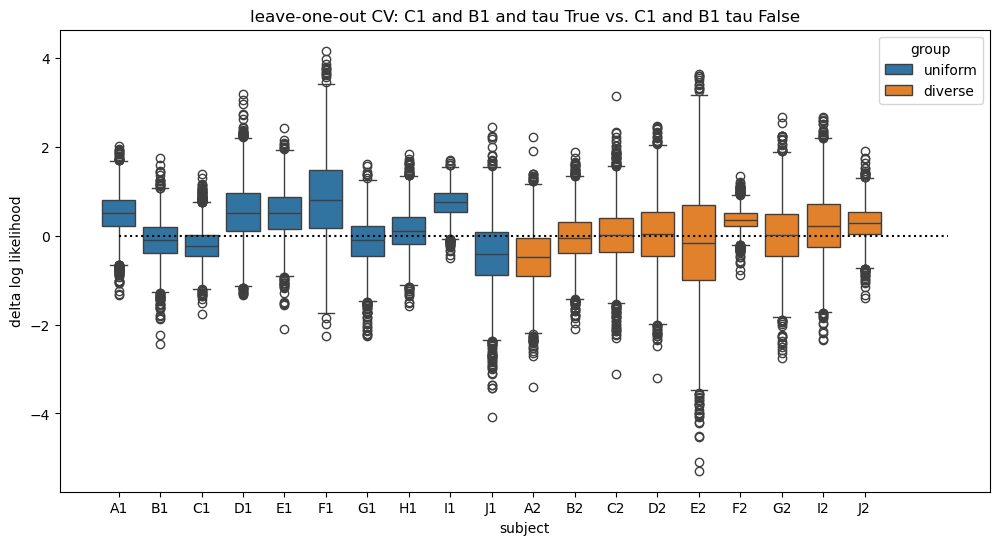

In [7]:
from scipy.stats import wilcoxon
plt.figure(figsize=(12,6))
cd1 = 1
nb1 = 1
te1 = False
cd2 = 1
nb2 = 1
te2 = True

df_c2a = xval_df.query("context == @cd1 and nback == @nb1 and tau == @te1 and train_condition == 'LOO'").reset_index().set_index(["subject", "draws"])
df_c2b = xval_df.query("context == @cd2 and nback == @nb2 and tau == @te2 and train_condition == 'LOO'").reset_index().set_index(["subject", "draws"])


df_c2b["delta log likelihood"] = df_c2b["log_likelihood"] - df_c2a["log_likelihood"]
df_c2b["delta log likelihood"] = df_c2b["log_likelihood"] - df_c2a["log_likelihood"]

df_c3a = df_c2a.reset_index().groupby(["subject", "train_condition", "group"]).agg({"log_likelihood" : "mean"}).reset_index().set_index("subject");
df_c3b = df_c2b.reset_index().groupby(["subject", "train_condition", "group"]).agg({"log_likelihood" : "mean"}).reset_index().set_index("subject");

df_c3b["delta log likelihood"] = df_c3b["log_likelihood"] - df_c3a["log_likelihood"]
df_c3b["delta log likelihood"] = df_c3b["log_likelihood"] - df_c3a["log_likelihood"]


sns.boxplot(data=df_c2b, x="subject", y="delta log likelihood", hue="group")
# sns.pointplot(data=df_c3b, x="subject", y="delta", hue="group")
plt.plot([0, 20],[0,0],'k:')

print(df_c2b.groupby("group")["delta log likelihood"].mean())
# print(df_c3b.groupby("group")["delta"].mean())
plt.title(f"leave-one-out CV: C{cd2} and B{nb2} and tau {te2} vs. C{cd1} and B{nb1} tau {te1}")

wilcoxon(df_c3b["delta log likelihood"])

In [8]:
model.get_within_session_timeconstant_labels()

[]